# Serverless Neural Network Codebook: 10 Epoch Training Example
## Libraries, Global and Event Variables
### Libraries
The packages that will be needed by the Lambda Functions are declared in the `Utils` Python file, namely: 
- [datetime](https://docs.python.org/2/library/datetime.html) provides classes for manipulating dates and times in both simple and complex ways.
- [numpy](http://www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test the model with unseen images at the end.
- [boto3](https://pypi.python.org/pypi/boto3) is the Amazon Web Services (AWS) Software Development Kit (SDK) for Python, which allows Python developers to write software that makes use of services like Amazon S3 and Amazon EC2.
- [json](https://docs.python.org/3/library/json.html) is a lightweight data interchange format inspired by JavaScript object literal syntax (although it is not a strict subset of JavaScript.
- [os](https://docs.python.org/3/library/os.html) is a module the provides a portable way of using operating system dependent functionality. Particularly the  `environ` object is a mapping object representing the environment.
- [uuid](https://docs.python.org/2/library/uuid.html#uuid.uuid4) creates a unique, random ID.
- The [io](https://docs.python.org/2/library/io.html) module provides the Python interfaces to stream handling.
- The Python interface to the [Redis](https://pypi.python.org/pypi/redis) key-value store.
- [math](https://docs.python.org/3/library/math.html) to determine the last mini-batch size when partitioning the Training Data Set into mini-batches.

In [1]:
# Import Libraries needed by the Lambda Function
import warnings; warnings.simplefilter('ignore')
import sys
import datetime
import math
import numpy as np
import h5py
import scipy
import os
from os import environ
import json
from json import dumps, loads
from boto3 import client, resource, Session
import botocore
import uuid
import io
import redis
from redis import StrictRedis as redis

In [2]:
# Import libraries needed for the Codebook
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (11.0, 10.0)

### S3 Trigger Event
To initiate the network training process, the dataset (**datasets.h5**) is uploaded to Amazon Simple Storage Services ([S3](https://aws.amazon.com/s3/)). This process triggers the S3 bucket event which starts the training process. A sample of the event payload sent to the SNN framework is as follows:

>**Note:** In order for the *10 Epoch Sample* to work, please update the following lines in the code below and add the name of the S3 Bucket created during deployment. For example:
```json
    "bucket": {
        "arn": "arn:aws:s3:::<<BUCKET Name>>",
        "name": "<<Bucket Name>>",
    ...
```
For this version of the implementation, the S3 Bucket is called **itsacat-demo-1** and the folder is called **training_input**.

In [3]:
# Simulate S3 event trigger data
event = {
    "Records": [
        {
            "eventVersion": "2.0",
            "eventTime": "1970-01-01T00:00:00.000Z",
            "requestParameters": {
                "sourceIPAddress": "127.0.0.1"
             },
            "s3": {
                "configurationId": "testConfigRule",
                "object": {
                    "eTag": "0123456789abcdef0123456789abcdef",
                    "sequencer": "0A1B2C3D4E5F678901",
                    "key": "training_input/datasets.h5",
                    "size": 1024
                },
                "bucket": {
                    "arn": "arn:aws:s3:::itsacat-demo-1",
                    "name": "itsacat-demo-1",
                    "ownerIdentity": {
                        "principalId": "EXAMPLE"
                    }
                },
                "s3SchemaVersion": "1.0"
            },
            "responseElements": {
                "x-amz-id-2": "EXAMPLE123/5678abcdefghijklambdaisawesome/mnopqrstuvwxyzABCDEFGH",
                "x-amz-request-id": "EXAMPLE123456789"
            },
            "awsRegion": "us-east-1",
            "eventName": "ObjectCreated:Put",
            "userIdentity": {
                "principalId": "EXAMPLE"
            },
            "eventSource": "aws:s3"
        }
    ]
}
context = None

To establish client connectivity to the various AWS services that the function will leverage, the following code creates the needed clients for the various AWS services, as global variables.

### Global Variables
>**Note:** The AWS Region is declared at the time of deployment. The `rgn` variable is declared from the above event in order to simulate its functionality.

In [4]:
# Global Variables
"""
Note: The Region is specifically declared for
the 10 Epoch Sample
"""
rgn = 'us-east-1'
s3_client = client('s3', region_name=rgn) # S3 access
s3_resource = resource('s3')
sns_client = client('sns', region_name=rgn) # SNS
lambda_client = client('lambda', region_name=rgn) # Lambda invocations
redis_client = client('elasticache', region_name=rgn) # ElastiCache
# Retrieve the Elasticache Cluster endpoint
cc = redis_client.describe_cache_clusters(ShowCacheNodeInfo=True)
endpoint = cc['CacheClusters'][0]['CacheNodes'][0]['Endpoint']['Address']
# Set redis database to `10` as default for the main parameters
cache = redis(host=endpoint, port=6379, db=10)
dynamo_client = client('dynamodb', region_name=rgn)
dynamo_resource = resource('dynamodb', region_name=rgn)

## Function Overview
### Helper Functions
All Helper funcitons are defined within the `Utils` Python file.

In [5]:
# Helper Functions
def vectorize(x_orig):
    """
    Vectorize the image data into a matrix of column vectors
    
    Argument:
    x_orig -- Numpy array of image data
    
    Return:
    Reshaped/Transposed Numpy array
    """
    return x_orig.reshape(x_orig.shape[0], -1).T

def standardize(x_orig):
    """
    Standardize the input data
    
    Argument:
    x_orig -- Numpy array of image data
    
    Return:
    Call to `vectorize()`, stndrdized Numpy array of image data
    """
    return vectorize(x_orig) / 255

def initialize_data(parameters):
    """
    Extracts the training and testing data from S3, flattens, 
    standardizes and then initializes a random Weights and
    Bias object for each layer.

    Arguments:
    parameters -- The initial/running parameters dictionary object
    
    Returns:
    X -- Traing set features
    Y - Training set labels
    """
    # Load main dataset
    dataset = h5py.File('/tmp/datasets.h5', "r")

    # Create numpy arrays from the various h5 datasets
    train_set_x_orig = np.array(dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(dataset["train_set_y"][:]) # train set labels
    test_set_x_orig = np.array(dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(dataset["test_set_y"][:]) # test set labels

    # Reshape labels
    Y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))

    # Preprocess inputs
    X = standardize(train_set_x_orig)
    
    return X, Y

def to_cache(db, obj, name):
    """
    Serializes multiple data type to ElastiCache and returns
    the Key.
    
    Arguments:
    db -- The ElastiCache database
    obj -- the object to srialize. Can be of type:
            - Numpy Array
            - Python Dictionary
            - String
            - Integer
    name -- Name of the Key
    
    Returns:
    key -- For each type the key is made up of {name}|{type} and for
           the case of Numpy Arrays, the Length and Width of the 
           array are added to the Key.
    """
    # Test if the object to Serialize is a Numpy Array
    if 'numpy' in str(type(obj)):
        array_dtype = str(obj.dtype)
        if len(obj.shape) == 0:
            length = 0
            width = 0
        else:
            length, width = obj.shape
        # Convert the array to string
        val = obj.ravel().tostring()
        # Create a key from the name and necessary parameters from the array
        # i.e. {name}|{type}#{length}#{width}
        key = '{0}|{1}#{2}#{3}'.format(name, array_dtype, length, width)
        # Store the binary string to Redis
        cache = redis(host=endpoint, port=6379, db=db)
        cache.set(key, val)
        return key
    # Test if the object to serialize is a string
    elif type(obj) is str:
        key = '{0}|{1}'.format(name, 'string')
        val = obj
        cache = redis(host=endpoint, port=6379, db=db)
        cache.set(key, val)
        return key
    # Test if the object to serialize is an integer
    elif type(obj) is int:
        key = '{0}|{1}'.format(name, 'int')
        # Convert to a string
        val = str(obj)
        cache = redis(host=endpoint, port=6379, db=db)
        cache.set(key, val)
        return key
    # Test if the object to serialize is a dictionary
    elif type(obj) is dict:
        # Convert the dictionary to a String
        val = json.dumps(obj)
        key = '{0}|{1}'.format(name, 'json')
        cache = redis(host=endpoint, port=6379, db=db)
        cache.set(key, val)
        return key
    else:
        print("The Object is not a supported serialization type")
        raise

def from_cache(db, key):
    """
    De-serializes binary object from ElastiCache by reading
    the type of object from the name and converting it to
    the appropriate data type
    
    Arguments:
    db -- ElastiCache database
    key -- Name of the Key to retrieve the object
    
    Returns:
    obj -- The object converted to specifed data type
    """
    # Check if the Key is for a Numpy array containing
    # `float64` data types
    if 'float64' in key:
        cache = redis(host=endpoint, port=6379, db=db)
        val = cache.get(key)
        # De-serialize the value
        array_dtype, length, width = key.split('|')[1].split('#')
        if int(length) == 0:
            obj = np.float64(np.fromstring(val))
        else:
            obj = np.fromstring(val, dtype=array_dtype).reshape(int(length), int(width))
        return obj
    # Check if the Key is for a Numpy array containing
    # `int64` data types
    elif 'int64' in key:
        cache = redis(host=endpoint, port=6379, db=db)
        val = cache.get(key)
        # De-serialize the value
        array_dtype, length, width = key.split('|')[1].split('#')
        obj = np.fromstring(val, dtype=array_dtype).reshape(int(length), int(width))
        return obj
    # Check if the Key is for a json type
    elif 'json' in key:
        cache = redis(host=endpoint, port=6379, db=db)
        obj = cache.get(key)
        return json.loads(obj)
    # Chec if the Key is an integer
    elif 'int' in key:
        cache = redis(host=endpoint, port=6379, db=db)
        obj = cache.get(key)
        return int(obj)
    # Check if the Key is a string
    elif 'string' in key:
        cache = redis(host=endpoint, port=6379, db=db)
        obj = cache.get(key)
        return obj
    else:
        sns_message = "`from_cache` Error:\n" + str(type(obj)) + "is not a supported serialization type"
        publish_sns(sns_message)
        print("The Object is not a supported de-serialization type")
        raise

def sigmoid(z):
    """
    Computes the sigmoid of z.
    
    Arguments:
    z -- A scalar or numpy array of any size
    Return:
    sigmoid(z)
    """
    return 1. / (1. + np.exp(-z))

def relu(z):
    """
    Implement the ReLU function.
    
    Arguments:
    z -- Output of the linear layer, of any shape
    Returns:
    a -- Post-activation parameter, of the same shape as z
    """
    a = np.maximum(0, z)
    # Debug statement
    #assert(a.shape == z.shape)
    return a

def sigmoid_backward(dA, z):
    """
    Implement the derivative of the sigmoid function.
    
    Arguments:
    dA -- Post-activation gradient, of any shape
    z -- Cached linear activation from Forward prop
    
    Returns:
    dZ -- Gradient of the Cost with respect to z
    """
    s = 1. / (1. + np.exp(-z))
    dZ = dA * s * (1 - s)
    # Debug statement
    #assert(dZ.shape == z.shape)
    return dZ

def relu_backward(dA, z):
    """
    Implement the backward propagation for a single ReLU unit.
    
    Arguments:
    dA -- Post-activation gradient, of any shape
    z -- Cached linear activation from Forward propagation
    
    Return:
    dz -- Gradient of the Cost with respect to z
    """
    dz = np.array(dA, copy=True) #converting dz to a correct object
    # When z <= 0, set dz to 0 as well
    dz[z <= 0] = 0
    # Debug statement
    #assert (dz.shape == z.shape)
    return dz

def random_minibatches(X, Y, batch_size=64):
    """
    Creates a list of random smaller batches of X and Y
    
    Arguments:
    X -- Training examples input data of size (input size, no. of examples)
    Y -- Training example labels vector of size (1, no. of examples)
    batch_size -- Size of the mini batches
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_x, mini_batch_Y)
    """
    #np.random.seed(seed)
    m = X.shape[1] # no. of training examples
    mini_batches = [] 
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape(1, m)
    
    # Step 2: Partition (shuffled_X, shuffled_Y), minus the end case.
    num_complete_minibatches = math.floor(m / batch_size) # No. of mini batches
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * batch_size : (k + 1) * batch_size]
        mini_batch_Y = shuffled_Y[:, k * batch_size : (k + 1) * batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Step 3: Deal with the end case
    if m % batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def inv_counter(name, invID, task):
    """
    Manages the Counter assigned to a unique Lambda Invocation ID, by
    either setting it to 0, updating it to 1 or querying the value.
   
    Arguments:
    name -- The Name of the function being invoked
    invID -- The unique invocation ID created for the specific invocation
    task -- Task to perform: set | get | update
    """
    table = dynamo_resource.Table(name)
    if task == 'set':
        table.put_item(
            Item={
                'invID': invID,
                'cnt': 0
            }
        )
        
    elif task == 'get':
        task_response = table.get_item(
            Key={
                'invID': invID
            }
        )
        item = task_response['Item'] 
        return int(item['cnt'])
        
    elif task == 'update':
        task_response = table.update_item(
            Key={
                'invID': invID
            },
            UpdateExpression='SET cnt = :val1',
            ExpressionAttributeValues={
                ':val1': 1
            }
        )

def propogate(direction, batch, layer, parameter_key):
    """
    Determines the amount of "hidden" units based on the layer and loops
    through launching the necessary `NeuronLambda` functions with the 
    appropriate state. Each `NeuronLambda` implements the cost function 
    OR the gradients depending on the direction.

    Arguments:
    direction -- The current direction of the propagation, either `forward` or `backward`.
    epoch -- Integer representing the "current" epoch to close out.
    layer -- Integer representing the current hidden layer.

    Note: When launching NeuronLambda with multiple hidden unit,
    remember to assign an ID, also remember to start at 1
    and not 0. for example:
    num_hidden_units = 5
    for i in range(1, num_hidden_units + 1):
        # Do stuff
    """
    # Get the parameters for the layer
    parameters = from_cache(db=batch, key=parameter_key)
    num_hidden_units = parameters['neurons']['layer'+str(layer)]
    
    # Build the NeuronLambda payload
    payload = {}
    # Add the parameters to the payload
    payload['state'] = direction
    payload['batch'] = batch
    payload['layer'] = layer
    
    # Determine process based on direction
    if direction == 'forward':
        # Launch Lambdas to propagate forward
        # Prepare the payload for `NeuronLambda`
        # Update parameters with this function's updates
        parameters['layer'] = layer
        payload['parameter_key'] = to_cache(db=batch, obj=parameters, name='parameters')

        # Debug Statements
        #print("Starting Forward Propagation for batch " + str(batch) + ", layer " + str(layer))

        # Prepare the payload for `NeuronLambda`
        for i in range(1, num_hidden_units + 1):
            payload['id'] = i
            if i == num_hidden_units:
                payload['last'] = "True"
            else:
                payload['last'] = "False"
            payload['activation'] = parameters['activations']['layer' + str(layer)]
            
            # Debug Statements
            #print("Payload to be sent NeuronLambda: \n" + dumps(payload, indent=4, sort_keys=True))
                        
            neuron_handler(event=payload, context=None)
            
        return
    
    elif direction == 'backward':
        # Launch Lambdas to propagate backward        
        # Prepare the payload for `NeuronLambda`
        # Update parameters with this functions updates
        parameters['layer'] = layer
        payload['parameter_key'] = to_cache(db=batch, obj=parameters, name='parameters')
        
        # Debug Statements
        #print("Starting Backward Propagation for batch " + str(batch) + ", layer " + str(layer))

        # Prepare the payload for `NeuronLambda`
        for i in range(1, num_hidden_units + 1):
            payload['id'] = i
            if i == num_hidden_units:
                payload['last'] = "True"
            else:
                payload['last'] = "False"
            payload['activation'] = parameters['activations']['layer' + str(layer)]
            
            # Debug Statements
            #print("Payload to be sent NeuronLambda: \n" + dumps(payload, indent=4, sort_keys=True))
            
            neuron_handler(event=payload, context=None)
            
        return

    else:
        raise

def start_batch(batch, layer, parameter_key):
    """
    Starts a new mini-batch and configures the necessary
    state tracking objects for the batch.
    
    Arguments:
    batch -- Integer representing the "current" mini-batch
    layer -- Integer representing the current hidden layer
    """
    # Configure state parameters for this batch
    parameters = from_cache(db=batch, key=parameter_key)
    parameters['layer'] = layer
    parameter_key = to_cache(
        db=batch,
        obj=parameters,
        name='parameters'
    )
    
    # Start Forward propagation
    propogate(
        direction='forward',
        batch=batch,
        layer=layer+1,
        parameter_key=parameter_key
    )

def vectorizer(Outputs, Layer, batch, parameters):
    """
    Creates a matrix of the individual neuron output for better vectorization.
    
    Arguments:
    Outputs -- ElastiCache key to search for the data from `NeuronLambda`
               e.g. 'a' for activations; 'dw' for Weight Derivatives
    Layer -- Layer to search for neuron output that need to vectorized
    batch -- The current mini-batch
    parameters -- The current mini-batch parameters
    
    Returns:
    result -- Matrix matching the size for the entire layer
    """
    # Use the following Redis command to ensure a pure string is return for the key
    r = redis(host=endpoint, port=6379, db=batch, charset="utf-8", decode_responses=True)
    search_results = []
    # Compile a list of all the neurons in the search layer based on the search criteria
    for n in range(1, parameters['neurons']['layer'+str(Layer)]+1):
        tmp = r.keys('layer'+str(Layer)+'_'+str(Outputs)+'_'+str(n)+'|*')
        search_results.append(tmp)
    # Created an ordered list of neuron data keys
    key_list = []
    for result in search_results:
        key_list.append(result[0])
    # Create a dictionary of neuron data
    Dict = {}
    for data in key_list:
        Dict[data] = from_cache(db=batch, key=data)
    # Number of Neuron Activations for the search layer
    num_neurons = parameters['neurons']['layer'+str(Layer)]
    # Create a numpy array of the results, depending on the number
    # of neurons (a Matrix of Activations)
    matrix = np.array([arr.tolist() for arr in Dict.values()])
    if num_neurons == 1:
        # Single Neuron Activation
        dims = (key_list[0].split('|')[1].split('#')[1:])
        matrix = matrix.reshape(int(dims[0]), int(dims[1]))
    else:
        # Multiple Neuron Activations
        matrix = np.squeeze(matrix)
    
    return matrix

def update_parameters_with_gd(W, b, dW, db, learning_rate, batch, layer, parameters):
    """
    Updates parameters using one step of gradient descent for a layer.
    
    Arguments:
    W -- Matrix of the Weights for the layer
    b -- Vector of the Bias for the layer
    dW -- Matrix of the Derivatives of  Weights for the layer
    db -- Vector of the Derivatives of the Bias for the layer
    learning_rate -- Learning rate for the network, scalar
    batch -- Current mini-batch
    layer -- Current layer being optimized
    
    Returns:
    parameter_key -- Updated parameter key with Weight and Bias data keys
    """
    # Run gradient descent
    W_prime = W - learning_rate * dW
    b_prime = b - learning_rate * db
    
    # Update the current batch ElastiCache with Weights and Bias
    parameters['data_keys']['W'+str(layer+1)] = to_cache(
        db=batch,
        obj=W_prime,
        name='W'+str(layer+1)
    )
    parameters['data_keys']['b'+str(layer+1)] = to_cache(
        db=batch,
        obj=b_prime,
        name='b'+str(layer+1)
    )
    
    # Update parameters for the mini-batch
    parameter_key = to_cache(
        db=batch,
        obj=parameters,
        name='parameters'
    )
    
    return parameter_key

### Lambda Handler Functions
#### `launch_handler(event, context)`
This `lambda_handler()` is triggered by the S3 event where training data is uploaded to S3. It further initializes the various components needed, such as:
1. State tracking Objects:
    - Overall Results (Cost) for each Epoch.
    - Gradients for each layer.
    - Initial and updated Weight parameter for each layer.
    - Initial and updated Bias parameter for each layer.
2. DynamoDB Storage:
    - Invocation ID for each Lambda Function invocation to prevent duplicate invocation.
    >**Note:** The DynamoDB Initialization is **NOT** recorded within the **Codebook**.
3. Preprocessing the Input Data: 
    - Read in the initial *training*, *test* of Cat and Non-cat images.
    - The function initially loads the data in `h5py` format and extracts the *training* and *test* data.
    - The function further performs any standardization and normalization of the input data.
    - The function also "*flattens*" the data into a column vector, thus performing **Vectorization**.
    - This data is dumped to ElastiCache and will thus serve as **Layer 0** of the Neural Network.
4. Initialize the mini-batches
    - Initial shuffle and mini-batch partitioning of the pre-processed training data.
5. Master Environment and State Tracking Variables:
    - Loading the initial Neural Network Parameters (`parameters.json`) and augmenting these parameter with the state variables during the training process. The settings include overall parameters used by the `trainer` and `neuron` Lambda Functions, such as:
        - Total number of epochs/iterations.
        - Total number of batches.
        - Total number of layers in the Neural Network (including the Output layer).
        - Total number of "neurons" in each layer.
        - The activation function to be used for each layer.  
    - Initializing the **Hash Keys** for the various data sets in ElastiCache to be used by the subsequent functions to get access to the numpy arrays.

In [6]:
def launch_handler(event, context):
    # Determine if this is the initial launch of the function
    if not event.get('state') == 'next':
        # This is the first invocation, therefore set up the initial parameters
        import shutil
        source = './datasets/datasets.h5'
        target = '/tmp/'
        assert not os.path.isabs(source)
        try:
            shutil.copy(source, target)
        except IOError as e:
            print("Unable to copy local datasets file. %s" % e)
        
        # Extract the neural network parameters from S3
        input_bucket = s3_resource.Bucket(str(event['Records'][0]['s3']['bucket']['name']))
        dataset_key = str(event['Records'][0]['s3']['object']['key'])
        settings_key = dataset_key.split('/')[-2] + '/parameters.json'
        try:
            input_bucket.download_file(settings_key, '/tmp/parameters.json')
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == '404':
                print(sns_message)
            else:
                raise
        with open('/tmp/parameters.json') as parameters_file:
            parameters = json.load(parameters_file)

        # Start building the Master parameters
        # Input data set and parameter bucket
        parameters['s3_bucket'] = event['Records'][0]['s3']['bucket']['name']
        parameters['s3_key'] = event['Records'][0]['s3']['object']['key']
        # Restrict codebook epochs to 10
        parameters['epochs'] = 10
        # Initial epoch for tracking
        parameters['epoch'] = 0
        # Initialize hash key tracking object
        parameters['data_keys'] = {}
        
        # Initialize and pre-process the training set
        X, Y = initialize_data(parameters)
        
        # Initialize the Weights and Bias using ReLU Initialization
        # for the ReLU neurons
        for l in range(1, parameters['layers']+1):
            if l == 1:
                """
                Note: This assumes Layer 1 uses the ReLU Activation.
                """
                # Standard Wieght initialization for ReLU
                W = np.random.randn(
                    parameters['neurons']['layer'+str(l)],
                    X.shape[0]
                ) * np.sqrt((2.0 / X.shape[0]))
            else:
                if parameters['activations']['layer'+str(l)] == 'sigmoid':
                    # Standard Weight initialization
                    W = np.random.randn(
                        parameters['neurons']['layer'+str(l)],
                        parameters['neurons']['layer'+str(l-1)]
                    ) / np.sqrt(parameters['neurons']['layer'+str(l-1)])
                else:
                    # Xavier Weight initialization for ReLu
                    W = np.random.randn(
                        parameters['neurons']['layer'+str(l)],
                        parameters['neurons']['layer'+str(l-1)]
                    ) * np.sqrt((2.0 / parameters['neurons']['layer'+str(l-1)]))
            # Standard Bias initialization
            b = np.zeros((parameters['neurons']['layer'+str(l)], 1))
            # Upload the Weights and Bias to ElastiCache Master DB
            parameters['data_keys']['W'+str(l)] = to_cache(db=15, obj=W, name='W'+str(l))
            parameters['data_keys']['b'+str(l)] = to_cache(db=15, obj=b, name='b'+str(l))
        
        # Upload the pre-processed data sets to the Master ElastiCache DB (db=15)
        # and update the parameters with the keys
        parameters['data_keys']['X'] = to_cache(db=15, obj=X, name='X')
        parameters['data_keys']['Y'] = to_cache(db=15, obj=Y, name='Y')
        
        # Initialize mini-batches
        batch_size = parameters['batch_size']
        batches = random_minibatches(X, Y, batch_size)
        parameters['num_batches'] = len(batches)
        
        # Initialize DynamoDB table for tracking Costs
        # Get the list of current DynamoDB Tables
        current_tables = dynamo_client.list_tables()
        if 'Costs' in current_tables['TableNames']:
            # Delete the exisiting `Costs` table
            dynamo_client.delete_table(TableName='Costs')
            waiter = dynamo_client.get_waiter('table_not_exists')
            waiter.wait(TableName='Costs')

        # Create the "fresh" `Costs` table
        table = dynamo_resource.create_table(
            TableName='Costs',
            KeySchema=[
                {
                    'AttributeName': 'epoch',
                    'KeyType': 'HASH'
                },
            ],
            AttributeDefinitions=[
                {
                    'AttributeName': 'epoch',
                    'AttributeType': 'N'
                },
            ],
            ProvisionedThroughput={
                'ReadCapacityUnits': 5,
                'WriteCapacityUnits': 5
            }
        )
        table.meta.client.get_waiter('table_exists').wait(TableName='Costs')
        
        # Initialize the Results tracking object
        results = {}
        results['Start'] = str(datetime.datetime.now())
        # Initialize tracking for first epoch
        results['epoch0'] = {}
        parameters['data_keys']['results'] = to_cache(
            db=15, obj=results, name='results'
        )
        
        # Finalize master parameters to ElastiCache
        master_parameter_key = to_cache(
            db=15, obj=parameters, name='parameters'
        )
                
        # Configure batch specific parameters
        current_batch = -1
        for batch in batches:
            # Create parameters that are specific to the batch, `batch_parameters`
            current_batch += 1
            (batch_X, batch_Y) = batch
            m = batch_X.shape[1]
            batch_parameters = parameters
            batch_parameters['batch_ID'] = int(current_batch)
            batch_parameters['data_keys']['A0'] = to_cache(
                db=current_batch,
                obj=batch_X,
                name='A0'
            )
            batch_parameters['data_keys']['Y'] = to_cache(
                db=current_batch,
                obj=batch_Y,
                name='Y'
            )
            batch_parameters['data_keys']['m'] = to_cache(
                db=current_batch,
                obj=m,
                name='m'
            )
            
            # Debug Statements
            #print("\n"+"\n"+"Batch {} Parameters: ".format(current_batch))
            #print(dumps(batch_parameters, indent=4, sort_keys=True))
            
            # Upload Batch parameters to respective ElastiCache database
            batch_parameter_key = to_cache(
                db=current_batch,
                obj=batch_parameters,
                name='parameters'
            )
            
            # Confirm Batch key matches Master key
            assert(str(batch_parameter_key) == str(master_parameter_key))
            
            # Initialize the payload for current batch to `TrainerLambda`
            payload = {}
            payload['state'] = 'start' # Initialize overall state
            payload['batch'] = int(current_batch)
            payload['parameter_key'] = master_parameter_key # Master parameter key
            
            # Launch `trainer_handler()` for the example.
            trainer_handler(event=payload, context=None)
        
    else:        
        # Determine current Epoch status
        parameters = from_cache(db=15, key=event.get('parameter_key'))
        epoch = parameters['epoch']
        
        if epoch == parameters['epochs'] - 1:
            # This is the final epoch, therefore close out training
            # and clean up.
            
            # Create dictionary of model parameters for prediction app
            params = {}

            # Consolidate the results from the parallel mini-batches.
            # Step 1: Get the lowest Cost for EACH mini-batch from 
            # DynamoDB and determine which mini-batch has the lowest
            # Error.
            Costs = []
            table = dynamo_resource.Table('Costs')
            response = table.get_item(
                Key={
                    'epoch': epoch
                }
            )
            
            item = response['Item']
            # Get the cost for each mini-batch
            for k, v in item.items():
                if 'batch' in k:
                    Costs.append(float(v))
            # Calculate the index of the lowest Cost
            best_batch = np.argmin(Costs)

            # Step 2: Get the optimized Weights and Bias (by layer) from
            # the mini-batch with the lowest error and upload these as
            # the Weights and Bias for the prediction app.
            for l in range(1, parameters['layers']+1):
                # Get the weights from ElastiCache
                W = from_cache(db=best_batch, key=parameters['data_keys']['W'+str(l)])
                b = from_cache(db=best_batch, key=parameters['data_keys']['b'+str(l)])
                # Update the model parameters for the prediction app
                params['W'+str(l)] = W
                params['b'+str(l)] = b
            
            # Create a model parameters file for use by prediction app
            with h5py.File('/tmp/params.h5', 'w') as h5file:
                for key in params:
                    h5file['/' + key] = params[key]
            # Upload model parameters file to S3
            s3_resource.Object(
                parameters['s3_bucket'],
                'predict_input/params.h5'
            ).put(Body=open('/tmp/params.h5', 'rb'))            
            
            # Debug Statements
            print("Training Completed successfully!\n"+"Final Cost = "+dumps(Costs[best_batch]))
            
            # Update the final results with the average cost
            final_results = from_cache(db=15, key=parameters['data_keys']['results'])
            final_results['epoch'+str(epoch)]['cost'] = Costs[best_batch]
            # Add the end time to the results
            final_results['End'] = str(datetime.datetime.now())
            # Upload the final results to S3
            results_obj = s3_resource.Object(parameters['s3_bucket'],'training_results/results.json')
            try:
                results_obj.put(Body=json.dumps(final_results))
            except botocore.exceptions.ClientError as e:
                print(e)
                raise
        
        else:
            # This is not the final Epoch, therefore process the next
            # epoch by consolidating the results from the parallel
            # mini-batches.
            # Step 1: Get the lowest Cost for EACH mini-batch form 
            # DynamoDB and determine which mini-batch has the lowest
            # Error.
            Costs = []
            table = dynamo_resource.Table('Costs')
            response = table.get_item(
                Key={
                    'epoch': epoch
                }
            )
            
            item = response['Item']
            # Get the cost for each mini-batch
            for k, v in item.items():
                if 'batch' in k:
                    Costs.append(float(v))
            # Calculate the index of the lowest Cost
            best_batch = np.argmin(Costs)

            # Adding temporary parameters placeholder in case current epoch
            # produces the best Cost.
            params = {}

            # Step 2: Get the optimized Weights and Bias (by layer) from
            # the mini-batch with the lowest error and upload these as
            # the Weights and Bias for the predicton app.
            for l in range(1, parameters['layers']+1):
                # Get the weights from ElastiCache
                W = from_cache(db=best_batch, key=parameters['data_keys']['W'+str(l)])
                b = from_cache(db=best_batch, key=parameters['data_keys']['b'+str(l)])
                # Update the model parameters for the pnext epoch
                parameters['data_keys']['W'+str(l)] = to_cache(db=15, obj=W, name='W'+str(l))
                parameters['data_keys']['b'+str(l)] = to_cache(db=15, obj=b, name='b'+str(l))

                # Update params in case current epoch is below threshold
                params['W'+str(l)] = W
                params['b'+str(l)] = b

            # Debug Statements
            print("Cost after Epoch {} = {}".format(epoch, Costs[best_batch]))
            
            # Update the results for this epoch with the average cost and
            # send status updates for epochs every 100 epochs
            update_results = from_cache(db=15, key=parameters['data_keys']['results'])
            update_results['epoch'+str(epoch)]['cost'] = Costs[best_batch]
            
            # Close off current Epoch and move onto the next
            # Initialize new mini-batches
            batch_size = parameters['batch_size']
            X, Y = initialize_data(parameters)
            batches = random_minibatches(X, Y, batch_size)
            parameters['num_batches'] = len(batches)
            
            # Initialize tracking for next epoch
            epoch += 1
            parameters['epoch'] = epoch
            update_results['epoch'+str(epoch)] = {}
            parameters['data_keys']['results'] = to_cache(
                db=15, obj=update_results, name='results'
            )
            
            # Finalize master parameters to ElastiCache
            master_parameter_key = to_cache(
                db=15, obj=parameters, name='parameters'
            )
            
            # Configure batch specific parameters
            current_batch = -1
            for batch in batches:
                # Create parameters that are specific to the batch, `batch_parameters`
                current_batch += 1
                (batch_X, batch_Y) = batch
                m = batch_X.shape[1]
                batch_parameters = parameters
                batch_parameters['batch_ID'] = int(current_batch)
                batch_parameters['data_keys']['A0'] = to_cache(
                    db=current_batch,
                    obj=batch_X,
                    name='A0'
                )
                batch_parameters['data_keys']['Y'] = to_cache(
                    db=current_batch,
                    obj=batch_Y,
                    name='Y'
                )
                batch_parameters['data_keys']['m'] = to_cache(
                    db=current_batch,
                    obj=m,
                    name='m'
                )

                # Debug Statements
                #print("\n"+"\n"+"Batch {} Parameters: ".format(current_batch))
                #print(dumps(batch_parameters, indent=4, sort_keys=True))

                # Upload Batch parameters to respective ElastiCache database
                batch_parameter_key = to_cache(
                    db=current_batch,
                    obj=batch_parameters,
                    name='parameters'
                )

                # Confirm Batch key matches Master key
                assert(str(batch_parameter_key) == str(master_parameter_key))
                
                # Initialize the payload for current batch to `TrainerLambda`
                payload = {}
                payload['state'] = 'start' # Initialize overall state
                payload['batch'] = int(current_batch)
                payload['parameter_key'] = master_parameter_key # Master parameter key
                
                # Launch the `trainer_handler()` function for the 10 Epoch example.
                trainer_handler(event=payload, context=None)

#### `trainer_handler(event, context)`
This `lambda_handler()` function is the most critical function in the set in that it:
1. Tracks and updates the state across the Mini-batches and the various layers of the Neural Network.
2. Performs Vectorization on the Activation Row Vectors from each Neuron to create a *Matrix* of Activations.
3. Launches the various Neurons (`NeuronLambda`) in each layer and tracks their output for *Forward* or *Backward* propagation.
4. Calculates the *Cost* for each iteration of *Forward* propagation.
5. Performs *Gradient Descent* for the current Mini-Batch.
6. Calls the `LaunchLambda` to start the next Epoch.

In order to accomplish this, the `TrainerLambda` has three possible states, `start`, `forward` and `backward`:
1. `start`: This state starts the initial or subsequent training epochs and performs the following:
    - Initializes the new weights and bias for the epoch.
    - Updates the state table with these values.
2. `forward`: This state processes the *forward* propagation step and launches the various hidden layer Neurons and supplies the necessary state information to these functions, such as:
    - Input/Activation data location
    - Weights and Bias.
    - Hidden Layer No.
    - Number of Hidden Units.
    - Activation Function for the Layer.
3. `backward`: This state processes the *back* propagation step and launches the various hidden layer Neurons as well as supplies the necessary information for these functions, like:
    - Hidden Layer No.
    - Number of Hidden Units.
    - Current and previous Activations calculated from the forward propagation step.

In [7]:
def trainer_handler(event, context):
    """
    1. Processes the `event` variables from the various Lambda functions that call it, 
        i.e. `TrainerLambda` and `NeuronLambda`.
    2. Determines the "current" state and then directs the next steps.
    3. Performs Vectorization from the NeuronLambda forward propagation outputs.
    4. Calculates the Cost.
    5. Performs Gradient Descent given the gradients from the backward propagation outputs.
    """
    # Get the current state from the invoking lambda function
    state = event.get('state')
    batch = event.get('batch')
    layer = event.get('layer')
    parameters = from_cache(db=batch, key=event.get('parameter_key'))
    
    # Execute appropriate action based on the current state
    if state == 'forward':
        # Get the Vectorized matrix of Activations from `NeuronLambda` output
        A = vectorizer(Outputs='a', Layer=layer-1, batch=batch, parameters=parameters)
        
        # Add the `A` Matrix to `data_keys` for later Neuron use
        A_name = 'A' + str(layer-1)
        parameters['data_keys'][A_name] = to_cache(db=batch, obj=A, name=A_name)
        
        # Update ElastiCache with this function's data
        parameter_key = to_cache(db=batch, obj=parameters, name='parameters')
        
        # Determine the location within Forwardprop
        if layer > parameters['layers']:
            # Location is at the end of forwardprop, therefore calculate Cost
            # Get the training examples data and no. examples (`Y` and `m`)
            Y = from_cache(db=batch, key=parameters['data_keys']['Y'])
            m = from_cache(db=batch, key=parameters['data_keys']['m'])
            
            # Calculate the Cross-Entropy Cost
            cost = (1. / m) * (-np.dot(Y, np.log(A).T) - np.dot(1 - Y, np.log(1 - A).T))
            cost = np.squeeze(cost)
            assert(cost.shape == ())
            
            # Add batch cost to DynamoDB Costs tracking object
            table = dynamo_resource.Table('Costs')
            table.update_item(
                Key={
                    'epoch': parameters['epoch']
                },
                UpdateExpression="Set #batch = :costval",
                ExpressionAttributeValues={
                    ':costval': str(cost)
                },
                ExpressionAttributeNames={
                    '#batch': 'batch'+str(batch)
                }
            )

            #print("Cost after Epoch {}, Batch {}: {}".format(parameters['epoch'],batch,cost))
            
            # Initialize Backprop
            # Calculate the derivative of the Cost with respect to the last
            # activation and ensure that `Y` is the correct shape as the
            # last activation.
            Y = Y.reshape(A.shape)
            dA = - (np.divide(Y, A) - np.divide(1 - Y, 1 - A))
            dA_name = 'dA' + str(layer-1)
            parameters['data_keys'][dA_name] = to_cache(db=batch, obj=dA, name=dA_name)
            
            # Update parameters from this function in ElastiCache
            parameter_key = to_cache(db=batch, obj=parameters, name='parameters')
            
            # Start Backpropagation on NeuronLambda
            propogate(direction='backward', batch=batch, layer=layer-1, parameter_key=parameter_key)
            
        else:
            # Move to the next hidden layer for multiple layer networks
            # Debug statement
            #print("Propagating forward onto Layer " + str(layer))
            propogate(direction='forward', batch=batch, layer=layer, parameter_key=parameter_key)
            
    elif state == 'backward':
        # Vectorize the derivatives
        dZ = vectorizer(Outputs='dZ', Layer=layer+1, batch=batch, parameters=parameters)
        
        # Pre-process the derivatives of the Weights
        dW = vectorizer(Outputs='dw', Layer=layer+1, batch=batch, parameters=parameters)
        
        # Pre-process the derivatives of the Bias
        db = vectorizer(Outputs='db', Layer=layer+1, batch=batch, parameters=parameters)
        db = vectorizer(Outputs='db', Layer=layer+1, batch=batch, parameters=parameters)
        db = db.reshape(db.shape[0], 1)
        
        # Get the Learning rate
        learning_rate = parameters['learning_rate']
        
        # Determine the location within Backprop
        if batch == (parameters['num_batches'] - 1) and (layer == 0):
            # Location is at the end of the final mini-batch, therefore
            # get the necessary MASTER parameters for optimization and close
            # out the parallel run by launching `LaunchLambda`.
            W = from_cache(db=15, key=parameters['data_keys']['W'+str(layer+1)])
            b = from_cache(db=15, key=parameters['data_keys']['b'+str(layer+1)])
            
            # Update parameters for current layer to the mini-batch ElastiCache
            parameter_key = update_parameters_with_gd(
                W, b, dW, db,
                learning_rate,
                batch, layer,
                parameters
            )
            
            # Debug Statement
            #print("Training complete for batch {}, epoch {}".format(batch, parameters['epoch']))
            
            # Launch `LaunchLambda` to close out the mini-batches
            # Initialize the payload for initial batch to `LaunchLambda`
            payload = {}
            payload['state'] = 'next' # Initialize overall state
            payload['parameter_key'] = parameter_key
            
            # Launch `launch_handler()` function for 10 Epoch example.
            launch_handler(event=payload, context=None)
            
        elif (batch < parameters['num_batches'] - 1) and (layer == 0):
            # Location is at the end of the current mini-batch and
            # backprop is finished, therefore get the necessary 
            # MASTER parameters for optimization and simply close
            # out the mini-batch.
            W = from_cache(db=15, key=parameters['data_keys']['W'+str(layer+1)])
            b = from_cache(db=15, key=parameters['data_keys']['b'+str(layer+1)])
            
            # Update parameters for current layer to the mini-bacth ElastiCache
            parameter_key = update_parameters_with_gd(
                W, b, dW, db,
                learning_rate,
                batch, layer,
                parameters
            )
            # Debug Statement
            #print("Training complete for batch {}, epoch {}".format(batch, parameters['epoch']))
                        
        else:
            # Location is still within the backprop process, therefore 
            # get the necessary MASTER parameters for optimization and 
            # continue backprop for the mini-batch.
            W = from_cache(db=15, key=parameters['data_keys']['W'+str(layer+1)])
            b = from_cache(db=15, key=parameters['data_keys']['b'+str(layer+1)])
            
            # Calculate the current layer's activations with respect to the
            # Cost/Error.
            dA = np.dot(W.T, dZ)
            dA_name = 'dA'+str(layer)
            parameters['data_keys'][dA_name] = to_cache(
                db=batch,
                obj=dA,
                name=dA_name
            )
            
            # Update parameters for current layer to the mini-bacth ElastiCache
            parameter_key = update_parameters_with_gd(
                W, b, dW, db,
                learning_rate,
                batch, layer,
                parameters
            )
            
            # Move onto the the next hidden layer for multiple layer networks
            propogate(direction='backward', batch=batch, layer=layer, parameter_key=parameter_key)
            
    elif state == 'start':
        # Initialize the start of a mini-batch execution
        layer = 0
        start_batch(batch=batch, layer=layer, parameter_key=event.get('parameter_key'))

#### `neuron_handler(event, context)`
This `lambda_handler()` simulates a single *Perceptron* for both forward and backward propagation. If the state is `forward` then the function simulates forward propagation for $X$ to $Cost$ for the current layer. If the state is backward, then the function calculates the gradient of the derivative of the activation function for the current layer.

>**Note:** This function also moves the state to the next or previous layer, depending on the state.

In [8]:
def neuron_handler(event, context):
    """
    This Lambda Function simulates a single Perceptron for both 
    forward and backward propagation.
    """    
    # Get the current state
    state = event.get('state')
    batch = event.get('batch')
    layer = event.get('layer')
    # Get the ID of this individual neuron
    ID = event.get('id')
    # Determine is this is the last Neuron in the layer
    last = event.get('last')
    activation = event.get('activation')
    
    # Get the mini-batch parameters from Elasticache
    parameters = from_cache(db=batch, key=event.get('parameter_key'))

    # Debug Statement
    #print("Starting {} propagation on Neuron: {}, for Batch {} and Layer {}".format(state, str(ID), str(batch), str(layer)))
    
    # Forward propagation from A0 to Cost
    if state == 'forward':
        # Activations from the previous layer
        A_prev = from_cache(db=batch, key=parameters['data_keys']['A'+str(layer - 1)])
        # Get the MASTER weights for this neuron
        w = from_cache(db=15, key=parameters['data_keys']['W'+str(layer)])[ID-1, :]
        # Convert weights to a row vector
        w = w.reshape(1, w.shape[0])
        # Get the MASTER bias for this neuron as row vector
        b = from_cache(db=15, key=parameters['data_keys']['b'+str(layer)])[ID-1, :]
        # Perform the linear part of the layer's forward propagation
        z = np.dot(w, A_prev) + b
        # Upload the linear transformation results to batch ElastiCache for use with Backprop
        to_cache(db=batch, obj=z, name='layer'+str(layer)+'_z_'+str(ID))
        
        # Perform non-linear activation based on the activation function
        if activation == 'sigmoid':
            a = sigmoid(z)
        elif activation == 'relu':
            a = relu(z)
        else:
            # No other activation functions supported at this time
            pass
        # Upload the results to batch ElastiCache for `TrainerLambda` to vectorize
        to_cache(db=batch, obj=a, name='layer'+str(layer)+'_a_'+str(ID))

        # Debug Statements
        #print("Completed Forward Propgation for batch {}, layer {}.".format(str(batch), str(layer)))
        
        if last == 'True':
            # Update parameters with this Neuron's data
            parameters['layer'] = layer + 1
            # Build the state payload
            payload = {}
            payload['parameter_key'] = to_cache(db=batch, obj=parameters, name='parameters')
            payload['state'] = 'forward'
            payload['batch'] = batch
            payload['layer'] = layer + 1
            
            # Debug Statement
            #print("Payload to be sent to TrainerLambda: \n" + dumps(payload, indent=4, sort_keys=True))
            
            # Launch `trainer_handler()` for 10 Epoch example.
            trainer_handler(event=payload, context=None)
        
        return
    
    # Backprop from Cost to X (A0)
    elif state == 'backward':
        # Get necessary parameters for the mini-batch
        r = redis(host=endpoint, port=6379, db=batch, charset="utf-8", decode_responses=True)
        z_key = []
        for z in r.scan_iter(match='layer'+str(layer)+'_z_'+str(ID)+'*'):
            z_key.append(z)
        z = from_cache(db=batch, key=z_key[0])
        m = from_cache(db=batch, key=parameters['data_keys']['m'])
        A_prev = from_cache(
            db=batch,
            key=parameters['data_keys']['A'+str(layer-1)]
        )
        
        # Get the derivative of the current layer's activation,
        # based on the size of the layer.
        if layer == parameters['layers']:
            # This is the last layer in the network, then assume
            # a single neuron
            dA = from_cache(db=batch, key=parameters['data_keys']['dA'+str(layer)])
            # Get the MASTER weights for this layer
            W = from_cache(db=15, key=parameters['data_keys']['W'+str(layer)])
        else:
            dA = from_cache(db=batch, key=parameters['data_keys']['dA'+str(layer)])[ID-1, :]
            dA = dA.reshape(1, dA.shape[0])
            # Get the MASTER weights for this layer
            W = from_cache(db=15, key=parameters['data_keys']['W'+str(layer)])[ID-1, :]
            W = W.reshape(1, W.shape[0])
        
        # Calculate the deivative of the activations
        if activation == 'sigmoid':
            dZ = sigmoid_backward(dA, z)
        elif activation == 'relu':
            dZ = relu_backward(dA, z)
        else:
            # No other activations supported at this time
            pass
        
        # Upload the derivative of the activations for the 
        # mini-batch to ElastiCache, to be used by `TrainerLambda`.
        to_cache(db=batch, obj=dZ, name='layer'+str(layer)+'_dZ_'+str(ID))
        
        # Calculate the derivative of the Weights for this neuron
        dw = 1 / m * np.dot(dZ, A_prev.T)
        # Upload the derivative of the weight for the 
        # neuron to ElastiCache, to be used by `TrainerLambda`.
        to_cache(db=batch, obj=dw, name='layer'+str(layer)+'_dw_'+str(ID))
        
        # Debug statement
        assert(dw.shape == W.shape)
        
        # Calculate the derivate of the bias for this neuron
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        # Upload the derivative of the bias for the neuron
        # to ElastiCache, to be used by `TrainerLambda`.
        to_cache(db=batch, obj=db, name='layer'+str(layer)+'_db_'+str(ID))
        
        # Debug Statements
        #print("Completed Back Propagation for batch {}, layer {}".format(str(batch), str(layer)))
        
        if last == "True":
            # Update parameters with this Neuron's data
            parameters['layer'] = layer - 1
            # Build the state payload
            payload = {}
            payload['parameter_key'] = to_cache(db=batch, obj=parameters, name='parameters')
            payload['state'] = 'backward'
            payload['batch'] = batch
            payload['layer'] = layer - 1
            
            # Debug Statement
            #print("Payload to be sent to TrainerLambda: \n" + dumps(payload, indent=4, sort_keys=True))
            
            # Launch `trainer_handler()` function for 10 Epoch example.
            trainer_handler(event=payload, context=None)
            
        return

---
## Sample Model Training
### Overview
The following demonstrates training the model over $10$ Epochs. The final results are stored on S3 and can be analyzed after training has been completed.

### 1 - Trigger Event from S3
**Simulate the training data being uploaded to S3 and Launching the training process.**

In [9]:
# Simulate S3 event trigger data
launch_handler(event, context)

Cost after Epoch 0 = 0.697552051299509
Cost after Epoch 1 = 0.6911026222048886
Cost after Epoch 2 = 0.6911440560563916
Cost after Epoch 3 = 0.6910683365723302
Cost after Epoch 4 = 0.6880479468261324
Cost after Epoch 5 = 0.6882927473290885
Cost after Epoch 6 = 0.6889686249866858
Cost after Epoch 7 = 0.689053297296208
Cost after Epoch 8 = 0.6880330323923654
Training Completed successfully!
Final Cost = 0.6829213422676591


### 2 - View the Training Results
Although there are only $10$ iterations of the model training process, the Cost/Error can be visualized as follows:

Total Processing time: 5 minutes


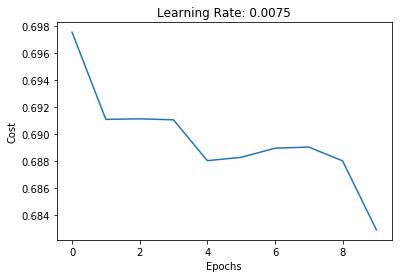

In [10]:
# View the Results object stored on S3
parameters = from_cache(db=15, key='parameters|json')
bucket = parameters['s3_bucket']
content = s3_resource.Object(bucket, 'training_results/results.json')
file = content.get()['Body'].read().decode('utf-8')
json_content = json.loads(file)
#print(json_content)
costs = []
for k, v in json_content.items():
    # Get the cost at each epoch
    if 'epoch' in k:
        costs.append(v.get('cost'))
    # Get the training start time
    elif 'Start' in k:
        start = datetime.datetime.strptime(v, "%Y-%m-%d %H:%M:%S.%f")
    # Get the training end time
    else:
        end = datetime.datetime.strptime(v, "%Y-%m-%d %H:%M:%S.%f")
delta = end - start
print("Total Processing time: {} minutes".format(int(delta.total_seconds() / 60)))
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title("Learning Rate: " + str(parameters['learning_rate']))
plt.show;

---
## Next: Full Model Training
Now that model training process (and code) can be verified, it's time to train the model using the serverless framework **OR** view the un-optimized *Prediction API*. Refer back to the [**README**](../README.md) on the next steps.